# LGBMをoptunaでチューニング

In [49]:
import seaborn as sns
import csv
import optuna
import optuna.integration.lightgbm as lgb
import itertools, logging, joblib
NOTE_NAME = "lgbm2"

In [2]:
ROUND = "237"
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"

In [3]:
# Load Dataset
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)
    return df

train = read_csv("../../dataset/numerai_dataset_237/numerai_training_data.csv")
tournament = read_csv("../../dataset/numerai_dataset_237/numerai_tournament_data.csv")

# reform
train.sort_index(axis=1, inplace=True)
tournament.sort_index(axis=1, inplace=True)
cols_feature = train.columns[train.columns.str.contains("feature_")]
cols_target  = train.columns[train.columns.str.contains("target_")]

In [4]:
train.head(1).append(tournament.tail(1))

,data_type,era,feature_charisma1,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma2,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma3,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma4,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma5,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma6,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma7,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma8,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_charisma9,feature_constitution1,feature_constitution10,feature_constitution100,feature_constitution101,feature_constitution102,feature_constitution103,feature_constitution104,feature_constitution105,feature_constitution106,feature_constitution107,feature_constitution108,feature_constitution109,feature_constitution11,feature_constitution110,feature_constitution111,feature_constitution112,feature_constitution113,feature_constitution114,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution2,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution3,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution4,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_constitution49,feature_constitution5,feature_constitution50,feature_constitution51,feature_constitution52,feature_constitution53,feature_constitution54,feature_constitution55,feature_constitution56,feature_constitution57,feature_constitution58,feature_constitution59,feature_constitution6,feature_constitution60,feature_constitution61,feature_constitution62,feature_constitution63,feature_constitution64,feature_constitution65,feature_constitution66,feature_constitution67,feature_constitution68,feature_constitution69,feature_constitution7,feature_constitution70,feature_constitution71,feature_constitution72,feature_constitution73,feature_constitution74,feature_constitution75,feature_constitution76,feature_constitution77,feature_constitution78,feature_constitution79,feature_constitution8,feature_constitution80,feature_constitution81,feature_constitution82,feature_constitution83,feature_constitution84,feature_constitution85,feature_constitution86,feature_constitution87,feature_constitution88,feature

In [5]:
# set logger
logger = logging.getLogger()  # root logger
fh = logging.FileHandler(f'{NOTE_NAME}/train.log')
fh.setFormatter(logging.Formatter('%(asctime)s|%(message)s', '%Y-%m-%d %H:%M:%S'))
logger.addHandler(fh)

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

---

In [6]:
# # Callback for logging
# from lightgbm.callback import _format_eval_result
# def log_evaluation(logger, period=1, show_stdv=True, level=logging.DEBUG):
#     def _callback(env):
#         if period > 0 and env.evaluation_result_list and (env.iteration + 1) % period == 0:
#             result = '\t'.join([_format_eval_result(x, show_stdv) for x in env.evaluation_result_list])
#             logger.log(level, '[{}]\t{}'.format(env.iteration+1, result))
#     _callback.order = 10
#     return _callback

In [9]:
# # Callback for eval records
# from scipy.stats import spearmanr
# class LGBMEvalHistory:
#     def __init__(self, X, y, eras=None):
#         self.X = X
#         self.y = y
#         self.eras = eras if eras is not None else np.zeros_like(y)
#         self.exposure = pd.DataFrame(columns=X.columns)
#         self.corr_by_era = pd.DataFrame(columns=np.unique(eras))
#         self.others = pd.DataFrame()  # 後で好きに追加
        
#     def calcFeatureExposure(self, pred:np.ndarray, rounds:int)->pd.DataFrame:
#         # pred: np.array
#         exposures = [spearmanr(pred, self.X[col])[0] for col in self.X.columns]
#         return pd.DataFrame([exposures], columns=self.X.columns, index=[rounds])
    
#     def calcCorrByEra(self, pred:np.ndarray, rounds:int)->pd.DataFrame:
#         # pred: np.array
#         res = pd.DataFrame(index=[rounds], columns=np.unique(self.eras))
#         for era in np.unique(self.eras):
#             n = (self.eras==era).sum()
#             score = np.corrcoef(
#                 np.argsort(np.argsort(pred[self.eras==era])) / n,
#                 self.y[self.eras==era].values.reshape(-1,)
#             )[0, 1]
#             res.loc[rounds, era] = score
#         return res  # pd.DataFrame
        
#     def callback(self, env):
#         pred = env.model.predict(self.X)
#         self.exposure = self.exposure.append(self.calcFeatureExposure(pred, env.iteration))
#         self.corr_by_era = self.corr_by_era.append(self.calcCorrByEra(pred, env.iteration))
#         self.others.loc[env.iteration, "mse"] = np.mean(np.square(self.y.values.reshape(-1,) - pred.reshape(-1,)))

In [12]:
# set train data
train_lgb = lgb.Dataset(train.loc[:, cols_feature], 
                        label=train[TARGET_NAME])
tournament_lgb = lgb.Dataset(tournament.query("data_type=='validation'").loc[:, cols_feature], 
                             tournament.query("data_type=='validation'")[TARGET_NAME])

In [13]:
## fit setting 
default_params = {
    'objective': 'regression',
    'metric': 'l2',
}

best_params, tuning_history = dict(), list()
model = lgb.LightGBMTuner(
    default_params, train_lgb, valid_sets=tournament_lgb, early_stopping_rounds=30,
    time_budget=3600*24, verbose_eval=False
)

In [ ]:
# fit
model.run()


feature_fraction, val_score: 0.124763:  14%|#4        | 1/7 [00:51<05:07, 51.33s/it]

In [ ]:
joblib.dump(model.best_booster, f"{NOTE_NAME}/best_model.pkl")

In [19]:
print(model.best_params)

{'objective': 'regression', 'metric': 'l2', 'feature_pre_filter': False, 'lambda_l1': 4.068570095193426e-08, 'lambda_l2': 2.0027294954299554e-08, 'num_leaves': 56, 'feature_fraction': 0.7, 'bagging_fraction': 0.6902229027724966, 'bagging_freq': 5, 'min_child_samples': 20}


In [18]:
print(model.best_score)

0.1247378840062219


In [47]:
fimp = pd.DataFrame({"colname": cols_feature, "fImp": model.best_booster.feature_importance()})
fimp["feature_category"] = fimp.colname.str.slice(8).str.replace("[0-9]", "")

/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: best_booster has been deprecated in v1.4.0. This feature will be removed in v3.0.0.
  """Entry point for launching an IPython kernel.


In [48]:
fimp.groupby("feature_category").fImp.describe()

,count,mean,std,min,25%,50%,75%,max
feature_category,,,,,,,,
charisma,86.0,2.872093,2.274133,0.0,1.00,2.0,4.00,9.0
constitution,114.0,2.096491,1.809363,0.0,1.00,2.0,3.00,8.0
dexterity,14.0,5.571429,4.345011,1.0,2.25,4.0,7.00,14.0
intelligence,12.0,3.750000,2.562846,1.0,1.75,3.0,5.25,9.0
strength,38.0,2.921053,2.198053,0.0,1.00,2.0,4.00,9.0
wisdom,46.0,2.282609,2.187470,0.0,1.00,2.0,3.00,11.0


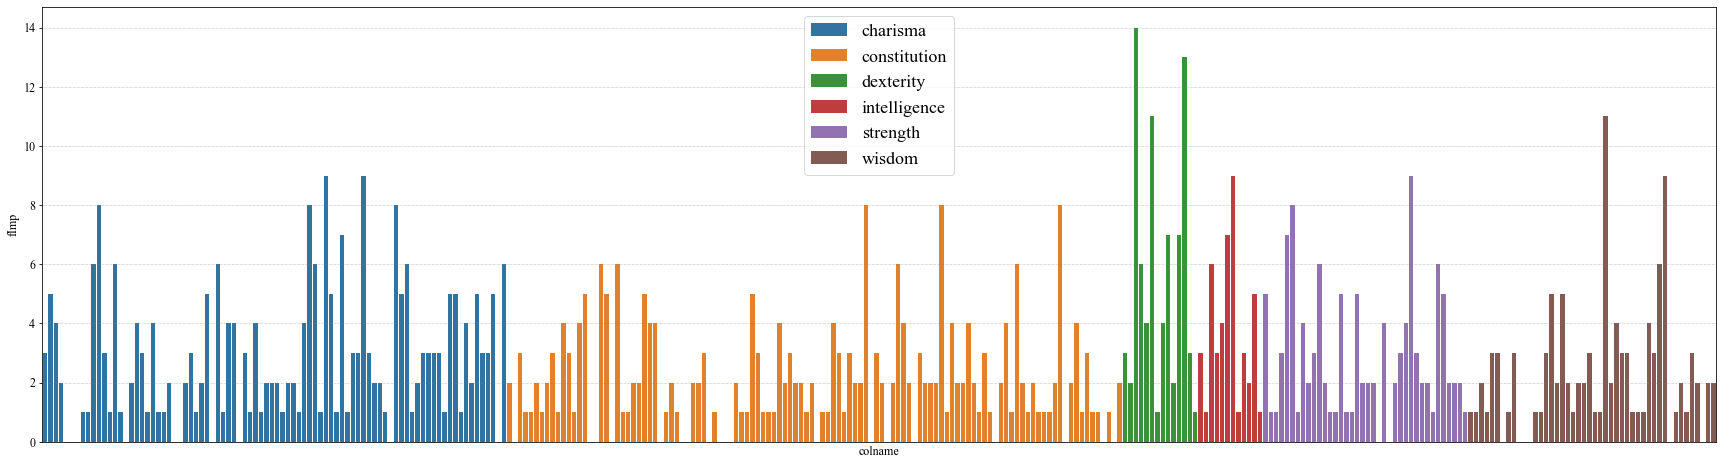

In [58]:
plt.figure(figsize=(30, 8))
sns.barplot(x='colname', y='fImp', data=fimp, hue=fimp.feature_category, dodge=False)
plt.xticks([]); plt.legend(fontsize=18);

In [29]:
model.best_params

{'objective': 'regression',
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 4.068570095193426e-08,
 'lambda_l2': 2.0027294954299554e-08,
 'num_leaves': 56,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.6902229027724966,
 'bagging_freq': 5,
 'min_child_samples': 20}